# 电力行业碳排放量预测模型

本notebook使用XGBoost模型预测电力行业的碳排放量，并利用utils.py中的函数计算特征。

In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from utils import PowerIndustryEmissions

# 设置中文显示
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

## 1. 数据加载与预处理

In [3]:
# 读取数据集
file_path = "./datasets/电力行业.csv"
df = pd.read_csv(file_path)

# 查看数据集前几行
df.head()

,企业,年份,退役设备SF6容量,修理设备SF6容量,退役设备SF6回收量,修理设备SF6回收量,退役设备数量,修理设备数量,供电量,售电量,区域电网排放因子,碳排放量
0,华电集团-山东分公司,2020,"2,800","1,200","2,520","1,080",9,6,"1,050,000","997,500",0.78,"358,050"
1,国电投-江苏风电场,2021,"1,500",800,"1,350",720,5,4,"320,000","304,000",0.72,"89,400"
2,中广核-广东核电基地,2022,"4,200","1,800","3,780","1,620",14,9,"2,800,000","2,660,000",0.62,"654,840"
3,华润电力-华中分部,2023,"3,600","1,500","3,420","1,425",12,7,"1,800,000","1,710,000",0.7,"357,525"
4,中国电建-西北项目,2024,"5,500","2,200","5,225","2,090",18,11,"4,200,000","3,990,000",0.8,"1,614,250"


In [4]:
# 查看数据基本信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   企业          120 non-null    object
 1   年份          120 non-null    int64 
 2   退役设备SF6容量   120 non-null    object
 3   修理设备SF6容量   120 non-null    object
 4   退役设备SF6回收量  120 non-null    object
 5   修理设备SF6回收量  120 non-null    object
 6   退役设备数量      120 non-null    int64 
 7   修理设备数量      120 non-null    int64 
 8   供电量         120 non-null    object
 9   售电量         120 non-null    object
 10  区域电网排放因子    120 non-null    object
 11  碳排放量        120 non-null    object
dtypes: int64(3), object(9)
memory usage: 11.4+ KB


In [5]:
# 数据预处理函数：移除千位分隔符和百分比符号
def clean_numeric(value):
    if isinstance(value, str):
        # 移除千位分隔符
        value = value.replace(",", "")
        # 处理带百分比的数值 (如有)
        if "%" in value:
            value = value.replace("%", "")
            value = float(value) / 100
        # 处理带括号的注释 (如 "2,250 (90%)")
        if "(" in value:
            value = value.split("(")[0].strip()
    return value

In [6]:
# 修改数据清洗函数以处理格式如 "2250 (90%)" 的值
def clean_numeric(value):
    if isinstance(value, str):
        # 移除千位分隔符
        value = value.replace(",", "")
        # 处理带括号的百分比 (如 "2250 (90%)" 或 "970 (97%)")
        if "(" in value and ")" in value:
            value = value.split("(")[0].strip()
        # 处理带百分比的数值 (如有)
        if "%" in value:
            value = value.replace("%", "")
            value = float(value) / 100
    return value


# 应用数据清洗函数并转换为数值类型
numeric_columns = [
    "退役设备SF6容量",
    "修理设备SF6容量",
    "退役设备SF6回收量",
    "修理设备SF6回收量",
    "退役设备数量",
    "修理设备数量",
    "供电量",
    "售电量",
    "区域电网排放因子",
    "碳排放量",
]

for col in numeric_columns:
    df[col] = df[col].apply(clean_numeric).astype(float)

# 检查处理后的数据
df.head()

,企业,年份,退役设备SF6容量,修理设备SF6容量,退役设备SF6回收量,修理设备SF6回收量,退役设备数量,修理设备数量,供电量,售电量,区域电网排放因子,碳排放量
0,华电集团-山东分公司,2020,2800.0,1200.0,2520.0,1080.0,9.0,6.0,1050000.0,997500.0,0.78,358050.0
1,国电投-江苏风电场,2021,1500.0,800.0,1350.0,720.0,5.0,4.0,320000.0,304000.0,0.72,89400.0
2,中广核-广东核电基地,2022,4200.0,1800.0,3780.0,1620.0,14.0,9.0,2800000.0,2660000.0,0.62,654840.0
3,华润电力-华中分部,2023,3600.0,1500.0,3420.0,1425.0,12.0,7.0,1800000.0,1710000.0,0.70,357525.0
4,中国电建-西北项目,2024,5500.0,2200.0,5225.0,2090.0,18.0,11.0,4200000.0,3990000.0,0.80,1614250.0


In [7]:
# 数据统计描述
df.describe()

,年份,退役设备SF6容量,修理设备SF6容量,退役设备SF6回收量,修理设备SF6回收量,退役设备数量,修理设备数量,供电量,售电量,区域电网排放因子,碳排放量
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,1.200000e+02,1.200000e+02,120.000000,1.200000e+02
mean,2022.225000,2382.083333,964.333333,2246.715833,909.134167,8.233333,5.150000,6.672917e+06,6.339271e+06,0.692500,1.067105e+06
std,1.682647,1485.624615,603.357181,1404.858105,569.622188,4.797992,2.761226,7.318771e+06,6.952833e+06,0.110433,1.706187e+06
min,2020.000000,600.000000,250.000000,540.000000,225.000000,3.000000,2.000000,2.800000e+05,2.660000e+05,0.480000,8.360000e+04
25%,2021.000000,1100.000000,450.000000,1067.000000,434.250000,4.000000,3.000000,1.675000e+06,1.591250e+06,0.600000,1.813500e+05
50%,2022.000000,1900.000000,750.000000,1773.000000,720.000000,7.000000,4.000000,3.550000e+06,3.372500e+06,0.700000,3.500875e+05
75%,2024.000000,3500.000000,1425.000000,3342.500000,1352.000000,12.000000,7.000000,8.750000e+06,8.312500e+06,0.800000,1.051875e+06
max,2025.000000,6000.000000,2500.000000,5700.000000,2375.000000,20.000000,12.000000,3.200000e+07,3.040000e+07,0.920000,6.612500e+06


## 2. 使用utils.py中的函数计算特征

In [8]:
# 计算SF6排放
df["sf6_emission"] = df.apply(
    lambda row: PowerIndustryEmissions.calculate_sf6_emission(
        row["退役设备SF6容量"],
        row["修理设备SF6容量"],
        row["退役设备SF6回收量"],
        row["修理设备SF6回收量"],
        row["退役设备数量"],
        row["修理设备数量"],
    ),
    axis=1,
)

# 计算输配电损失排放
df["transmission_loss_emission"] = df.apply(
    lambda row: PowerIndustryEmissions.calculate_transmission_loss_emission(
        row["供电量"], row["售电量"], row["区域电网排放因子"]
    ),
    axis=1,
)

# 查看新增的特征
df[["企业", "年份", "sf6_emission", "transmission_loss_emission", "碳排放量"]].head()

,企业,年份,sf6_emission,transmission_loss_emission,碳排放量
0,华电集团-山东分公司,2020,103248000.0,40950.0,358050.0
1,国电投-江苏风电场,2021,35133000.0,11520.0,89400.0
2,中广核-广东核电基地,2022,239478000.0,86800.0,654840.0
3,华润电力-华中分部,2023,85681500.0,63000.0,357525.0
4,中国电建-西北项目,2024,194546000.0,168000.0,1614250.0


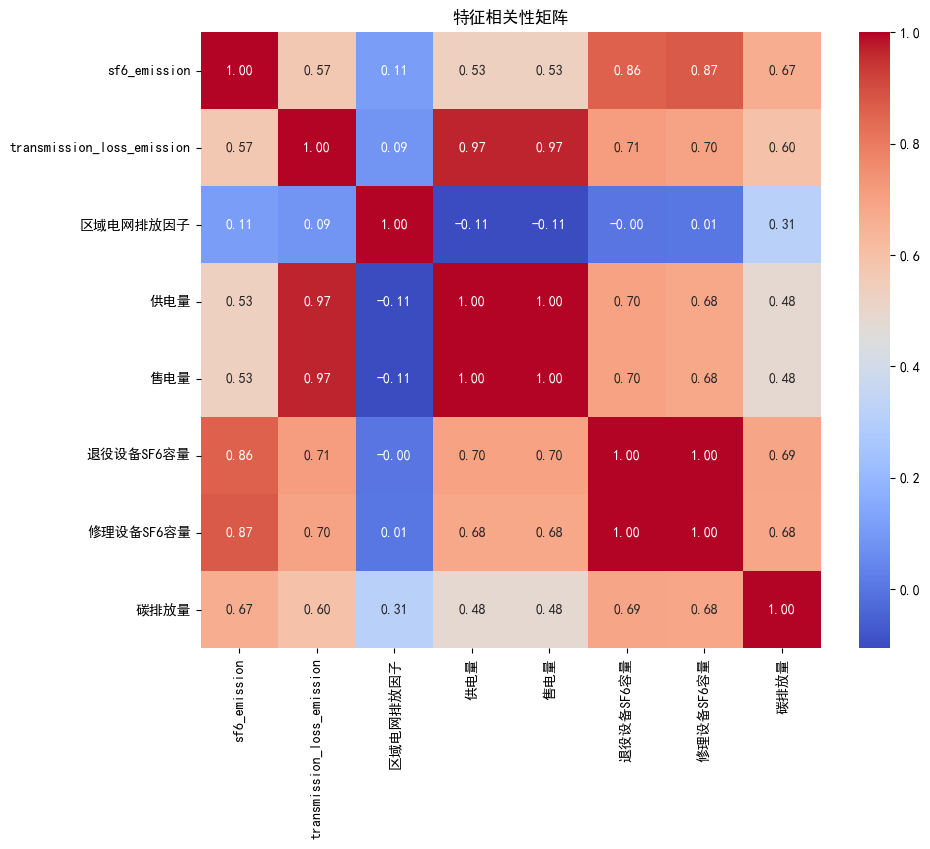

In [9]:
# 检查特征与目标变量的相关性
correlation_features = [
    "sf6_emission",
    "transmission_loss_emission",
    "区域电网排放因子",
    "供电量",
    "售电量",
    "退役设备SF6容量",
    "修理设备SF6容量",
    "碳排放量",
]
correlation_matrix = df[correlation_features].corr()

# 可视化相关性矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("特征相关性矩阵")
plt.show()

## 3. 数据分割与特征准备

In [10]:
# 准备特征和目标变量
# 我们将使用新计算的特征和其他可能有用的特征
features = [
    "sf6_emission",
    "transmission_loss_emission",
    # "区域电网排放因子",
    # "供电量",
    # "售电量",
    # "退役设备SF6容量",
    # "修理设备SF6容量",
    # "退役设备SF6回收量",
    # "修理设备SF6回收量",
    # "退役设备数量",
    # "修理设备数量",
]
X = df[features]
y = df["碳排放量"]

# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4. 训练XGBoost模型

In [11]:
# 定义初始XGBoost模型
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# 训练模型
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"均方误差 (MSE): {mse:.2f}")
print(f"均方根误差 (RMSE): {rmse:.2f}")
print(f"决定系数 (R²): {r2:.4f}")
print(f"平均绝对误差 (MAE): {mae:.2f}")

均方误差 (MSE): 289371821933.97
均方根误差 (RMSE): 537932.92
决定系数 (R²): 0.8881
平均绝对误差 (MAE): 304555.67


## 5. 模型优化

## 7. 预测与实际值对比可视化

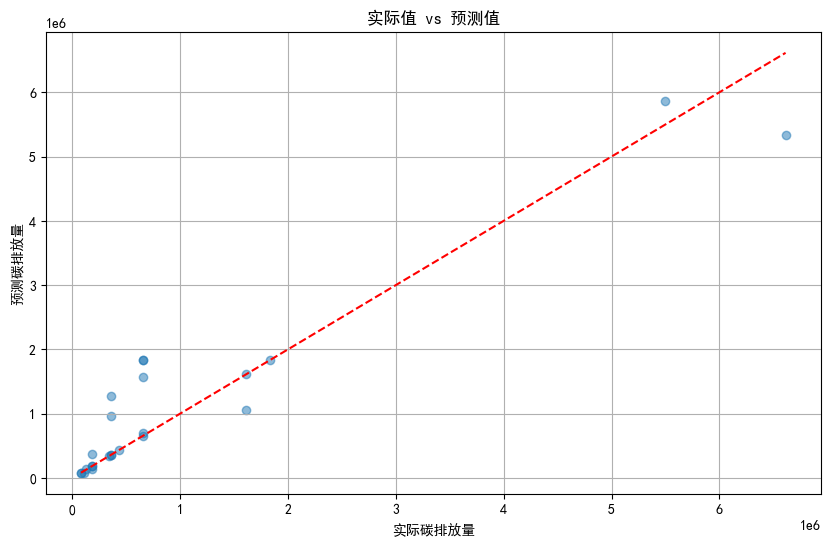

In [12]:
# 创建预测值与实际值的对比图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("实际碳排放量")
plt.ylabel("预测碳排放量")
plt.title("实际值 vs 预测值")
plt.grid(True)
plt.show()

## 8. 残差分析

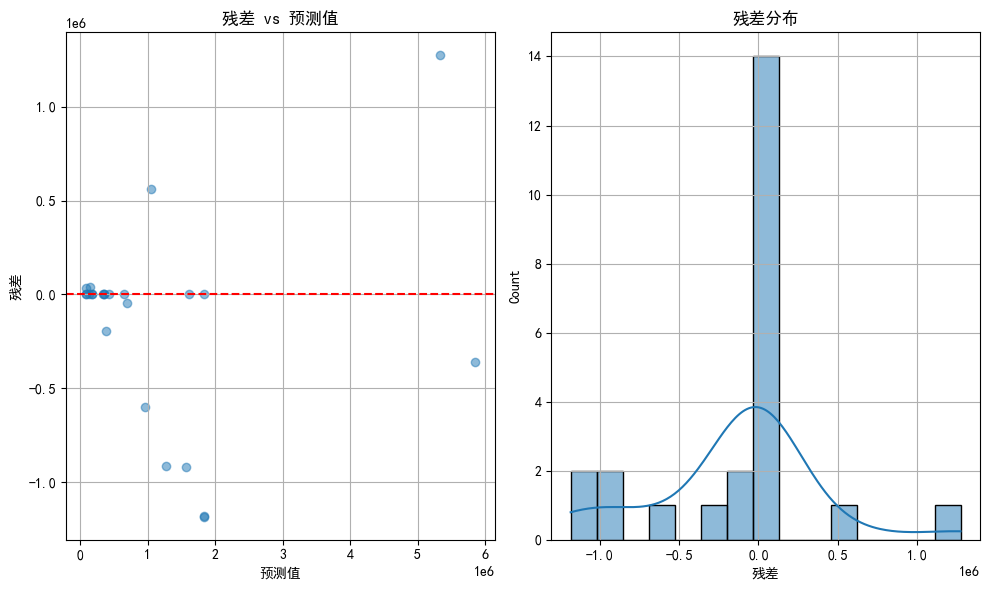

In [13]:
# 计算残差
residuals = y_test - y_pred

# 绘制残差分布
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("预测值")
plt.ylabel("残差")
plt.title("残差 vs 预测值")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel("残差")
plt.title("残差分布")
plt.grid(True)

plt.tight_layout()
plt.show()